In [1]:
import sys
sys.path.append("../")

from transformers import AutoTokenizer
from models.clip import CLIPTextTransformer, CLIPVisionTransformer, CLIPModel

In [2]:
from transformers import FlaxCLIPModel, AutoProcessor, AutoTokenizer

model = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")

2023-10-05 18:11:12.590728: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %fusion.5 = (u32[12648448]{0}, u32[12648448]{0}) fusion(), kind=kLoop, calls=%horizontally_fused_computation

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-10-05 18:11:12.696762: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.106122353s
Constant folding an instruction is taking > 1s:

  %fusion.5 = (u32[12648448]{0}, u32[12648448]{0}) fusion(), kind=kLoop, calls=%horizontally_fused_computation

This isn't necessarily a bug; constant-folding is inherently a trade-off betwee

In [3]:
import optax 
from flax.training import checkpoints, common_utils, train_state

import flax

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=1e-4,
    warmup_steps=5_000,
    decay_steps=100_000,
)

tx = optax.adamw(learning_rate=schedule, weight_decay=1e-4)
state = train_state.TrainState.create(apply_fn=model.__call__, params=model.params, tx=tx)
pstate = replicate(state)

In [4]:
logging_dir = '../logging/proposals/'
run_name = 'autumn-darkness-67'

In [5]:
ckpt_dir = "{}/{}/".format(logging_dir, run_name)  # Load SLURM run
restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=state,)

if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

In [6]:
from models.dataset_utils import make_dataloader, create_input_iter

files = ['../data/tfrecords/observations_1.tfrecord','../data/tfrecords/observations_2.tfrecord','../data/tfrecords/observations_3.tfrecord','../data/tfrecords/observations_4.tfrecord',]
ds = make_dataloader(files, batch_size=32, seed=42, split='val')
batches = iter(ds)

In [111]:
import jax.numpy as np

images, captions = next(iter(ds))
images = np.array(images)
captions = captions.numpy().tolist()
captions = [c.decode('utf-8') for c in captions]

In [112]:
from dm_pix import center_crop

images = center_crop(images, 224, 224)
inputs_images = processor(text=captions, images=(images * 255.), return_tensors="np", padding="max_length", truncation=False, max_length=77)

In [129]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")
claude_science_cat = ["star forming galaxies", "lyman alpha", "sfr", "dust", "crowded stellar field", "core-collapse supernova", "cosmology",  "gravitational lensing", "supernovae", "diffuse galaxies", "globular clusters", "stellar populations", "interstellar medium", "black holes", "dark matter", "galaxy clusters", "galaxy evolution", "galaxy formation", "quasars", "circumstellar disks", "exoplanets", "Kuiper Belt objects", "solar system objects", "cosmic web structure", "distant galaxies", "galaxy mergers", "galaxy interactions", "star formation", "stellar winds", "brown dwarfs", "neutron stars", "white dwarfs", "nebulae", "star clusters", "galaxy archeology", "galactic structure", "active galactic nuclei", "gamma-ray bursts", "stellar nurseries", "intergalactic medium", "galaxy clusters", "dark energy", "dwarf galaxies", "barred spiral galaxies", "irregular galaxies", "starburst galaxies", "dwarf galaxies", "low surface brightness galaxies", "ultra diffuse galaxies", "circumgalactic medium", "intracluster medium", "cosmic dust", "interstellar chemistry", "star formation histories", "initial mass function", "mass segregation", "stellar proper motions", "binary star systems", "open clusters", "pre-main sequence stars", "protostars", "protoplanetary disks", "jets and outflows", "interstellar shocks", "HII regions", "planetary nebulae", "supernova remnants", "stellar winds", "Wolf–Rayet stars", "OB stars", "red giants", "Cepheid variables", "RR Lyrae variables", "stellar oscillations", "stellar abundances", "stellar rotation", "stellar magnetic fields", "stellar dynamics", "compact stellar remnants", "Einstein rings", "asteroids", "comets", "trans-Neptunian objects", "cosmic microwave background", "reionization epoch", "first stars", "first galaxies", "high-redshift quasars", "primordial black holes", "resolved binaries", "binary stars"]
claude_science_cat_inputs = tokenizer(claude_science_cat, padding="max_length", truncation=True, max_length=77, return_tensors="np")

def display_content(image, paragraph, classes):
    # Create a figure and define the grid specification
    fig = plt.figure(figsize=(7, 5))
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 2])

    # Display the image on the left subplot (spanning all rows)
    ax0 = plt.subplot(gs[:, 0])
    ax0.imshow(image)
    ax0.axis('off')  # Turn off axis numbers and ticks

    # Display the list of classes on the right subplot (spanning all rows)
    ax2 = plt.subplot(gs[:, 1])
    # Add ranking numbers and the title "Top Classes"
    ranked_classes = [f"{i+1}. {cls}" for i, cls in enumerate(classes)]
    class_text = "Top Classes:\n" + "\n".join(ranked_classes)
    ax2.text(0.5, 0.5, class_text, ha='center', va='center', bbox=dict(boxstyle="square,pad=0.3", facecolor="white", edgecolor="black"))
    ax2.axis('off')  # Turn off axis numbers and ticks

    plt.tight_layout()
    plt.show()

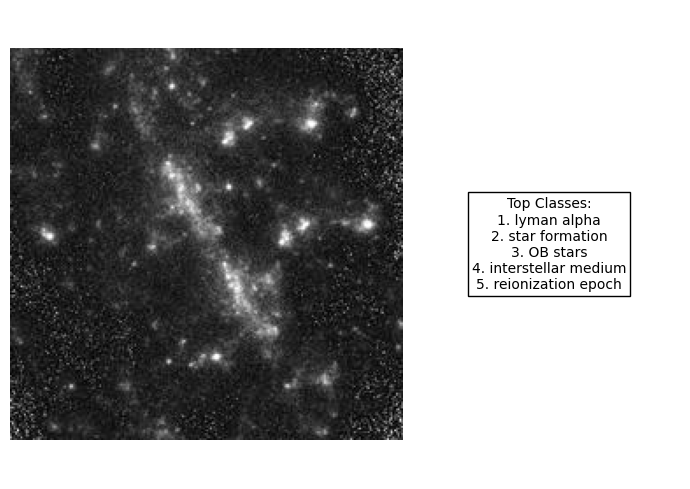

In [130]:
idx = 10

image_feat = model.get_image_features(inputs_images['pixel_values'][idx:idx + 1], params=restored_state.params);
text_feat = model.get_text_features(**claude_science_cat_inputs, params=restored_state.params)

cats = [claude_science_cat[i] for i in np.argsort((text_feat @ image_feat.T)[:, 0])[::-1]][:5]

display_content(images[idx], captions[idx], cats)

In [131]:
captions[idx]

'Category: ISM IN EXTERNAL GALAXIES. We have recently been granted time on FUSE to characterize the escape fraction of hydrogen Lyman continuum {Lyc} photons from a morphologically diverse set of star forming galaxies.  The FUSE program is designed to provide ~ 5 sigma detections of  Lyc photons emitted from star forming galaxies with escape fractions ~5%.\tWith this proposal we seek hydrogen Lyman alpha {Lya} observations of a representative subset of the FUSE program targets to constrain the observational relationship between Lyc, Lya, and hydrogen Balmer line emission in these systems.  Such observations explore the detailed balance between the simple optically thin {Case A} and optically thick {Case B} limits in recombination theory.  The ultimate goal of this program is to quantify the relationship between escaping Lya and Lyc emission and the first structures that form in the early universe.'